# Capstone: West Nile Virus

![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import warnings
#import plotly

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

# import the private function for calcuating the weight of importance (WOE) to eliminate features of less intrest
# directly downloaded from the github link: https://github.com/pankajkalania/IV-WOE/blob/main/iv_woe_code.py
from pywoe.iv_woe_code import get_iv_woe

from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")
%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets & feature selection

In [2]:
datadir = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

In [3]:
''' load the datasets '''

# load the main datasets that contain virus test results
train = pd.read_csv(os.path.join(datadir_pr, 'train_cleaned.csv'), parse_dates=['Date'], index_col='Date')
test = pd.read_csv(os.path.join(datadir_pr, 'test_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the weather data
weather = pd.read_csv(os.path.join(datadir_pr, 'weather_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the spraying data
spray = pd.read_csv(os.path.join(datadir_pr,'spray_cleaned.csv'), parse_dates=['DateTime'], index_col='DateTime')

# load the map data
mapdata = np.loadtxt(os.path.join(datadir,"mapdata_copyright_openstreetmap_contributors.txt"))
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

In [4]:
train.head(3)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Latitude2,Longitude2
Date,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,41.95,-87.80
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,41.95,-87.80
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,41.99,-87.77


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
 11  Latitude2               10506 non-null  float64
 12  Longitude2              10506 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 1.1+ MB


In [6]:
# drop address (and location) columns
col_drop = ['Address', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'Latitude2','Longitude2','Block','AddressAccuracy']
train_selected = train.drop(col_drop, axis=1)
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Species       10506 non-null  object
 1   NumMosquitos  10506 non-null  int64 
 2   WnvPresent    10506 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 328.3+ KB


In [7]:
''' 'NumMosquitos' & 'WnvPresent' are target data 
    We will choose either of targets when it splits by train_test '''

col_targets = ['NumMosquitos', 'WnvPresent']
targets = train_selected[['NumMosquitos', 'WnvPresent']]
train_selected = train_selected.drop(col_targets, axis=1)
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Species  10506 non-null  object
dtypes: object(1)
memory usage: 164.2+ KB


In [8]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NumMosquitos  10506 non-null  int64
 1   WnvPresent    10506 non-null  int64
dtypes: int64(2)
memory usage: 246.2 KB


In [9]:
train_selected.head(3)

,Species
Date,
2007-05-29,CULEX PIPIENS/RESTUANS
2007-05-29,CULEX RESTUANS
2007-05-29,CULEX RESTUANS


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Address                 116293 non-null  object 
 2   Species                 116293 non-null  object 
 3   Block                   116293 non-null  int64  
 4   Street                  116293 non-null  object 
 5   Trap                    116293 non-null  object 
 6   AddressNumberAndStreet  116293 non-null  object 
 7   Latitude                116293 non-null  float64
 8   Longitude               116293 non-null  float64
 9   AddressAccuracy         116293 non-null  int64  
 10  Latitude2               116293 non-null  float64
 11  Longitude2              116293 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 11.5+ MB


In [11]:
# drop address (and location) columns
col_drop = ['Id', 'Address', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'Latitude2','Longitude2', 'Block','AddressAccuracy']

test_selected = test.drop(col_drop, axis=1)

In [12]:
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Species  116293 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


<div class='alert alert-info'>
Note:
    
- The categorical feature (Species) will be handled by LabelEncoder.
- It might be replaced by one-hot code. 
</div>

### Label Encoder for the `Species` feature, which is categorical

In [13]:
train_selected.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [14]:
test_selected.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

> - Note that there is 'Unspecified Culex' in test datasets, which is not in train one. 
> - Since the number of the unspecified species is not large, we will remove it from the test dataset

In [15]:
test_selected = test_selected.loc[test_selected.Species!='UNSPECIFIED CULEX',:]

In [16]:
''' label encoder for the categorical feature '''

le_spec = LabelEncoder()

train_selected['Species'] = le_spec.fit_transform(train_selected['Species'])
test_selected['Species']  = le_spec.fit_transform(test_selected['Species'])

In [17]:
le_spec.classes_

array(['CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS'], dtype=object)

<div class='alert alert-warning'>
Note:

- there are Unspecified species in test dataset. They will be removed for now.
</div>

In [18]:
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101948 entries, 2008-06-11 to 2014-10-02
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   Species  101948 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


In [19]:
test_selected.head(3)

,Species
Date,
2008-06-11,2
2008-06-11,3
2008-06-11,1


### Split Weather data by two stations

In [20]:
weather.head(3)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,BR,0.0,0.0,29.38,30.09,13.0,4,13.4


In [21]:
''' add another feature that indicates whether it rains or not '''
weather['PrecipBool'] = weather['PrecipTotal'].apply(lambda x: 'N' if x==0.0 else 'Y')

weather[['PrecipTotal','PrecipBool']].sample(10)

,PrecipTotal,PrecipBool
Date,,
2009-09-25,0.16,Y
2011-10-05,0.00,N
2013-08-22,0.36,Y
2011-10-26,0.00,N
2009-08-10,0.00,N
2010-08-09,0.15,Y
2008-10-30,0.00,N
2011-06-22,0.02,Y
2012-10-26,0.00,N


In [22]:
''' add another feature that shows the duration of a day (sunrise to sunset) '''

weather['daylong'] = weather.Sunset - weather.Sunrise

In [23]:
''' label encoder for the categorical feature '''

label_enc = LabelEncoder()

weather['PrecipBool'] = label_enc.fit_transform(weather['PrecipBool'])

In [24]:
weather_stn1 = weather[weather.Station == 1].drop('Station', axis=1)
weather_stn2 = weather[weather.Station == 2].drop('Station', axis=1)

In [25]:
weather_stn1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   object 
 11  SnowFall     1472 non-null   float64
 12  PrecipTotal  1472 non-null   float64
 13  StnPressure  1472 non-null   float64
 14  SeaLevel     1472 non-null   float64
 15  ResultSpeed  1472 non-null   float64
 16  ResultDir    1472 non-null   int64  
 17  AvgSpeed     1472 non-null   float64
 18  PrecipBool   1472 non-null   i

In [26]:
weather_stn2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   object 
 11  SnowFall     1472 non-null   float64
 12  PrecipTotal  1472 non-null   float64
 13  StnPressure  1472 non-null   float64
 14  SeaLevel     1472 non-null   float64
 15  ResultSpeed  1472 non-null   float64
 16  ResultDir    1472 non-null   int64  
 17  AvgSpeed     1472 non-null   float64
 18  PrecipBool   1472 non-null   i

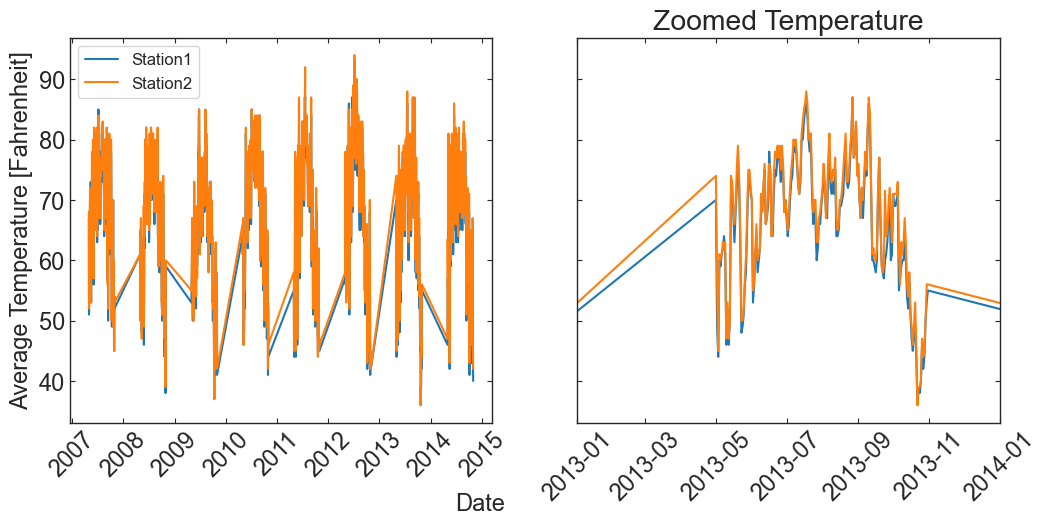

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)

axes[0].plot(weather_stn1.index, weather_stn1.Tavg, label='Station1')
axes[0].plot(weather_stn2.index, weather_stn2.Tavg, label='Station2')
#plt.locator_params(axis='x', nbins=1)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_ylabel('Average Temperature [Fahrenheit]')
axes[0].legend(loc='upper left', fontsize=12)

axes[1].plot(weather_stn1.index, weather_stn1.Tavg)
axes[1].plot(weather_stn2.index, weather_stn2.Tavg)
axes[1].set_xlim(datetime.date(2013,1,1), datetime.date(2014,1,1))
axes[1].tick_params(axis='x',labelrotation=45)
axes[1].set_title('Zoomed Temperature')

axes[1].annotate('Date', (0.4,0.01), xycoords='figure fraction', ha='center');

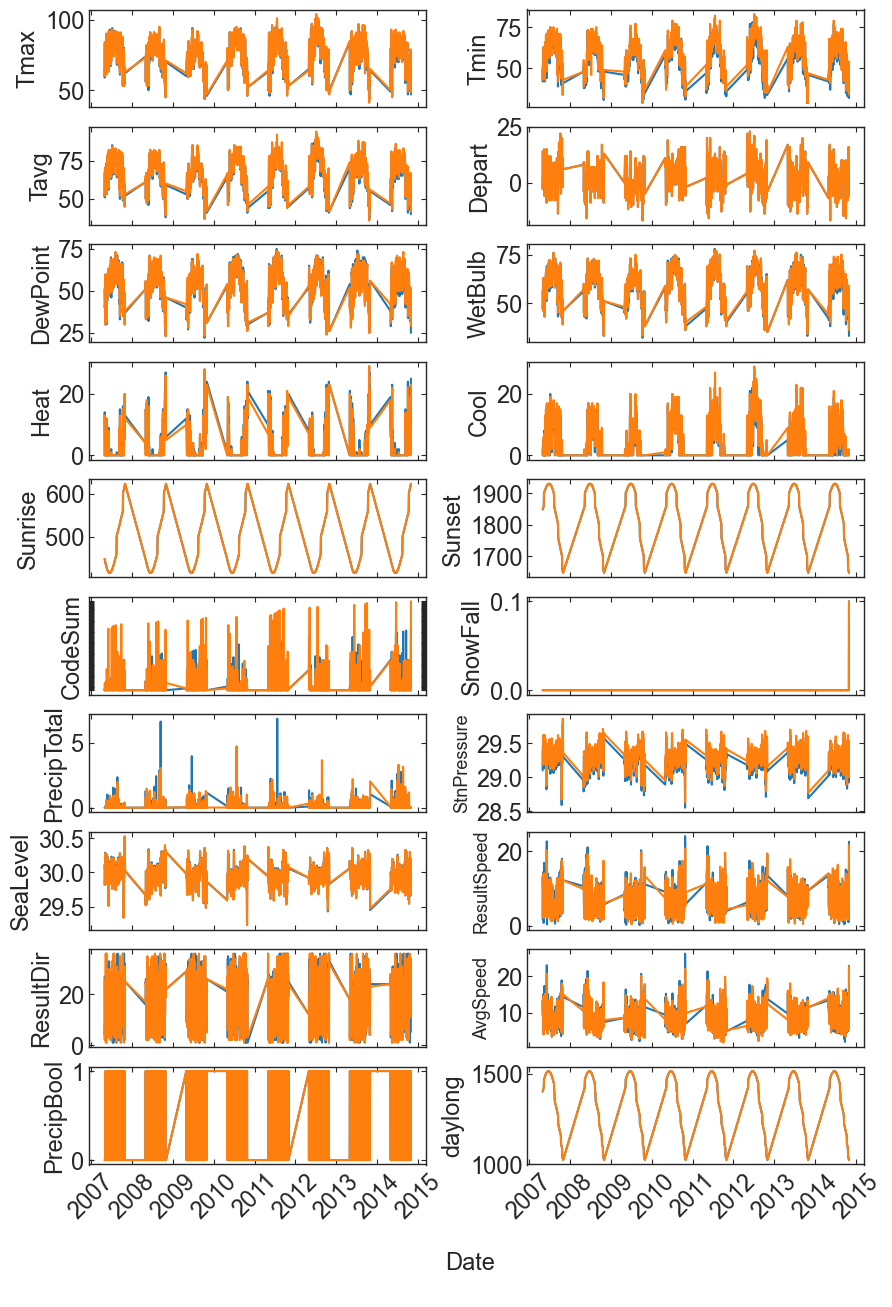

In [28]:
ncols = len(weather_stn1.columns) # number of total columns
ncol_win = 2
fig, axes = plt.subplots(int(ncols/ncol_win), ncol_win, figsize=(10,15), sharex=True)

for icol, iax in zip(weather_stn1.columns, axes.ravel()):
    iax.plot(weather_stn1.index, weather_stn1[icol], label='Stn1')
    iax.plot(weather_stn2.index, weather_stn2[icol], label='Stn2')
    iax.tick_params(axis='x',labelrotation=45)
    
    if icol=='CodeSum':
        iax.tick_params(axis='y',label1On=False)
    if icol in ['StnPressure','ResultSpeed','AvgSpeed']:
        iax.set_ylabel(icol, fontsize=13)
    else: iax.set_ylabel(icol)

axes[0,0].annotate('Date', (0.47,0.025), xycoords='figure fraction', ha='center');
fig.subplots_adjust(wspace=0.3)

In [29]:
weather_stn1.describe().T

,count,mean,std,min,25%,50%,75%,max
Tmax,1472.0,75.978940,11.503150,42.00,68.00,78.000,85.00,103.00
Tmin,1472.0,56.730978,10.347907,29.00,49.00,58.000,65.00,82.00
Tavg,1472.0,66.606658,10.511437,36.00,60.00,68.000,75.00,93.00
Depart,1472.0,1.954484,6.841110,-17.00,-3.00,2.000,7.00,23.00
DewPoint,1472.0,53.377717,10.670263,22.00,46.00,54.000,61.25,75.00
WetBulb,1472.0,59.052310,9.323150,32.00,53.00,60.000,66.00,78.00
Heat,1472.0,3.631114,6.133829,0.00,0.00,0.000,5.00,29.00
Cool,1472.0,5.237772,5.899382,0.00,0.00,3.000,10.00,28.00
Sunrise,1472.0,480.646739,65.344729,416.00,424.75,446.500,531.25,623.00
Sunset,1472.0,1847.347826,87.050615,1647.00,1792.25,1859.500,1922.25,1931.00


In [30]:
weather_stn2.describe().T

,count,mean,std,min,25%,50%,75%,max
Tmax,1472.0,76.353261,11.421482,41.00,69.000,78.00,85.000,104.00
Tmin,1472.0,58.889946,10.306855,29.00,51.000,60.00,67.000,83.00
Tavg,1472.0,67.871943,10.531672,36.00,61.000,70.00,76.000,94.00
Depart,1472.0,1.954484,6.841110,-17.00,-3.000,2.00,7.000,23.00
DewPoint,1472.0,53.538043,10.683121,23.00,46.000,55.00,62.000,74.00
WetBulb,1472.0,59.591033,9.244169,33.00,53.000,61.00,67.000,77.00
Heat,1472.0,3.204484,5.765144,0.00,0.000,0.00,4.000,29.00
Cool,1472.0,6.044837,6.279738,0.00,0.000,5.00,11.000,29.00
Sunrise,1472.0,480.646739,65.344729,416.00,424.750,446.50,531.250,623.00
Sunset,1472.0,1847.347826,87.050615,1647.00,1792.250,1859.50,1922.250,1931.00


<div class='alert alert-warning'>
Note:

- `SnowFall` feature seems unuseful as it has a single value only in 2015. So it would be better to be removed.
- Evidently, the weather data between Staion1 and Station2 is quite similar to each other as they are closely located. Therefore, we will use the weather value from Station1 for now and the result will be tested with Station2 values later if needed.
   
</div>

In [31]:
''' Drop 'SnowFall' features '''

drop_col = ['SnowFall']
weather_stn1.drop(drop_col, axis=1, inplace=True)
weather_stn2.drop(drop_col, axis=1, inplace=True)

In [32]:
weather_stn1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   object 
 11  PrecipTotal  1472 non-null   float64
 12  StnPressure  1472 non-null   float64
 13  SeaLevel     1472 non-null   float64
 14  ResultSpeed  1472 non-null   float64
 15  ResultDir    1472 non-null   int64  
 16  AvgSpeed     1472 non-null   float64
 17  PrecipBool   1472 non-null   int64  
 18  daylong      1472 non-null   f

### Label Encoder for the `CodeSum` feature, which is categorical

In [33]:
weather_stn1.CodeSum.unique()

array([' ', 'BR', 'RA', 'BR HZ', 'RA BR', 'RA VCTS', 'RA HZ',
       'TSRA RA BR HZ', 'HZ', 'TSRA BR HZ', 'TSRA RA BR', 'TSRA RA HZ',
       'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU', 'BR HZ FU',
       'TSRA RA VCTS', 'HZ VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'RA BR HZ', 'TSRA RA',
       'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA', 'TS TSRA RA BR VCTS',
       'TS RA', 'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TSRA RA FG+ FG BR', 'TSRA DZ FG+ FG BR HZ', 'TS TSRA',
       'TSRA HZ', 'TS', 'FG+ BR HZ', 'TS TSRA BR HZ', 'DZ BR HZ',
       'TS TSRA BR', 'RA BR FU', 'TS BR HZ', 'FG+ BR', 'FG+ MIFG BR',
       'TSRA RA FG BR', 'DZ', 'RA DZ BR HZ', 'TS BR', 'TS RA FG+ FG BR',
       'RA DZ FG+ FG BR', 'RA BR SQ', 'RA FG BR', 'RA BR HZ FU',
       'MIFG BCFG BR', 'TSRA RA FG+ FG BR HZ', 'TSRA DZ BR HZ',
       'TS TSRA RA FG BR HZ', 'RA DZ FG+ BR', 'TSRA FG+ BR HZ',
       'FG+ FG BR HZ', 'FG BR HZ', 'TS RA BR HZ', 'BC

In [34]:
weather_stn2.CodeSum.unique()

array([' ', 'BR HZ', 'HZ', 'TSRA RA BR', 'RA BR', 'TSRA RA', 'RA HZ',
       'TSRA BR HZ', 'RA BR HZ VCTS', 'RA', 'TSRA RA HZ', 'TSRA RA HZ FU',
       'BR', 'TSRA HZ', 'VCTS', 'TS TSRA RA BR HZ VCTS', 'TS TSRA BR HZ',
       'RA BR HZ', 'TSRA RA BR VCTS', 'TSRA RA DZ BR HZ', 'TSRA',
       'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA BR HZ', 'TS TSRA BR',
       'TSRA RA BR HZ', 'RA BCFG BR', 'TSRA BR', 'RA DZ', 'RA DZ BR',
       'TS TSRA RA HZ', 'TS BR', 'RA BR SQ', 'TS TSRA RA', 'TS RA',
       'TSRA RA VCTS', 'TSRA RA BR HZ VCTS', 'BR VCTS', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR', 'DZ BR HZ', 'DZ', 'FG+ FG BR', 'FG+ BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG BR HZ',
       'TS TSRA RA FG BR', 'TS BR HZ', 'BR HZ VCFG', 'TSRA RA FG+ BR',
       'TS TSRA RA VCTS', 'FU', 'TS', 'TS TSRA VCFG', 'TS TSRA HZ',
       'TS TSRA GR RA BR', 'HZ FU', 'RA BR HZ FU', 'FG+ BCFG BR',
       'TSRA RA FG+ FG BR', 'FG+', 'TSRA BR SQ', 'RA BR HZ VCFG',
       'RA FG+ BR', 'FG BR HZ', 

In [35]:
''' label encoder for the categorical feature '''

le_code1 = LabelEncoder()
weather_stn1['CodeSum'] = le_code1.fit_transform(weather_stn1['CodeSum'])

le_code2 = LabelEncoder()
weather_stn2['CodeSum'] = le_code2.fit_transform(weather_stn2['CodeSum'])

In [36]:
le_code1.classes_

array([' ', 'BCFG BR', 'BR', 'BR HZ', 'BR HZ FU', 'DZ', 'DZ BR',
       'DZ BR HZ', 'FG BR HZ', 'FG+ BR', 'FG+ BR HZ', 'FG+ FG BR HZ',
       'FG+ MIFG BR', 'HZ', 'HZ VCTS', 'MIFG BCFG BR', 'RA', 'RA BR',
       'RA BR FU', 'RA BR HZ', 'RA BR HZ FU', 'RA BR SQ', 'RA BR VCTS',
       'RA DZ', 'RA DZ BR', 'RA DZ BR HZ', 'RA DZ FG+ BCFG BR',
       'RA DZ FG+ BR', 'RA DZ FG+ FG BR', 'RA FG BR', 'RA FG+ MIFG BR',
       'RA HZ', 'RA SN', 'RA VCTS', 'TS', 'TS BR', 'TS BR HZ', 'TS RA',
       'TS RA BR', 'TS RA BR HZ', 'TS RA FG+ FG BR', 'TS TSRA',
       'TS TSRA BR', 'TS TSRA BR HZ', 'TS TSRA RA', 'TS TSRA RA BR',
       'TS TSRA RA BR HZ', 'TS TSRA RA BR VCTS', 'TS TSRA RA FG BR HZ',
       'TSRA', 'TSRA BR', 'TSRA BR HZ', 'TSRA BR HZ FU',
       'TSRA BR HZ VCTS', 'TSRA DZ BR HZ', 'TSRA DZ FG+ FG BR HZ',
       'TSRA FG+ BR HZ', 'TSRA HZ', 'TSRA RA', 'TSRA RA BR',
       'TSRA RA BR HZ', 'TSRA RA BR VCTS', 'TSRA RA FG BR',
       'TSRA RA FG+ FG BR', 'TSRA RA FG+ FG BR HZ', 'TSRA RA HZ',

In [37]:
weather_stn1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   int64  
 11  PrecipTotal  1472 non-null   float64
 12  StnPressure  1472 non-null   float64
 13  SeaLevel     1472 non-null   float64
 14  ResultSpeed  1472 non-null   float64
 15  ResultDir    1472 non-null   int64  
 16  AvgSpeed     1472 non-null   float64
 17  PrecipBool   1472 non-null   int64  
 18  daylong      1472 non-null   f

In [38]:
weather_stn1.head(3)

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,PrecipBool,daylong
Date,,,,,,,,,,,,,,,,,,,
2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0,0.0,29.10,29.82,1.7,27,9.2,0,1401.0
2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,2,0.0,29.38,30.09,13.0,4,13.4,0,1403.0
2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0,0.0,29.39,30.12,11.7,7,11.9,0,1405.0


### Add the shifted the weather data 
- the number of mosquitos can be affected the weather condition at prior days
- add the data with the shifted days 
- choice of weather features which may affect the current outcome:

In [39]:
shift_days = [1,3,7]   # choice of the shifted day 

# these features from the previous days may not affect the current outcome
col_drop = ['Depart', 'Sunset', 'Sunrise', 'SeaLevel']

for icol in weather_stn1.drop(col_drop, axis=1).columns:
    for iday in shift_days:
        shifted_col = '{:s}_{:d}d'.format(icol,iday)
        weather_stn1[shifted_col] = weather_stn1[icol].shift(iday)

weather_stn1.fillna(method='bfill', inplace=True)  # remove NaN values which was generated by the shifted days

In [40]:
weather_stn1.head()

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,...,ResultDir_7d,AvgSpeed_1d,AvgSpeed_3d,AvgSpeed_7d,PrecipBool_1d,PrecipBool_3d,PrecipBool_7d,daylong_1d,daylong_3d,daylong_7d
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,...,27.0,9.2,9.2,9.2,0.0,0.0,0.0,1401.0,1401.0,1401.0
2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,...,27.0,9.2,9.2,9.2,0.0,0.0,0.0,1401.0,1401.0,1401.0
2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,...,27.0,13.4,9.2,9.2,0.0,0.0,0.0,1403.0,1401.0,1401.0
2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444.0,1852.0,...,27.0,11.9,9.2,9.2,0.0,0.0,0.0,1405.0,1401.0,1401.0
2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443.0,1853.0,...,27.0,10.8,13.4,9.2,0.0,0.0,0.0,1408.0,1403.0,1401.0


In [41]:
''' simple check if there is any null values '''
print('number count of NaN values: {}'.format(weather_stn1.isnull().sum().sum()))

number count of NaN values: 0


# Merging dataset (main + weather)
- We will use the weather data from Station1 for now.

In [42]:
train_merged = train_selected.join(weather_stn1, on='Date')
test_merged  = test_selected.join(weather_stn1, on='Date')

In [43]:
train_merged['Year'] = train_merged.index.year
train_merged['Month'] = train_merged.index.month
train_merged['Day'] = train_merged.index.day
train_merged['Day_of_Year'] = train_merged.index.dayofyear

test_merged['Year'] = test_merged.index.year
test_merged['Month'] = test_merged.index.month
test_merged['Day'] = test_merged.index.day
test_merged['Day_of_Year'] = test_merged.index.dayofyear

In [44]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         10506 non-null  int64  
 1   Tmax            10506 non-null  int64  
 2   Tmin            10506 non-null  int64  
 3   Tavg            10506 non-null  float64
 4   Depart          10506 non-null  float64
 5   DewPoint        10506 non-null  int64  
 6   WetBulb         10506 non-null  float64
 7   Heat            10506 non-null  float64
 8   Cool            10506 non-null  float64
 9   Sunrise         10506 non-null  float64
 10  Sunset          10506 non-null  float64
 11  CodeSum         10506 non-null  int64  
 12  PrecipTotal     10506 non-null  float64
 13  StnPressure     10506 non-null  float64
 14  SeaLevel        10506 non-null  float64
 15  ResultSpeed     10506 non-null  float64
 16  ResultDir       10506 non-null  int64  
 17  AvgSpeed      

In [45]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101948 entries, 2008-06-11 to 2014-10-02
Data columns (total 69 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Species         101948 non-null  int64  
 1   Tmax            101948 non-null  int64  
 2   Tmin            101948 non-null  int64  
 3   Tavg            101948 non-null  float64
 4   Depart          101948 non-null  float64
 5   DewPoint        101948 non-null  int64  
 6   WetBulb         101948 non-null  float64
 7   Heat            101948 non-null  float64
 8   Cool            101948 non-null  float64
 9   Sunrise         101948 non-null  float64
 10  Sunset          101948 non-null  float64
 11  CodeSum         101948 non-null  int64  
 12  PrecipTotal     101948 non-null  float64
 13  StnPressure     101948 non-null  float64
 14  SeaLevel        101948 non-null  float64
 15  ResultSpeed     101948 non-null  float64
 16  ResultDir       101948 non-null  int64  

# Imbalanced Classification
- Undersampling the majority feature (here, positive West Nile Virus cases)
- Oversampling may cause some bias as it copies data, so undersampling may be considered as more natural way of resolution.

In [46]:
print(Counter(targets.WnvPresent))

Counter({0: 9955, 1: 551})


In [47]:
# instantiating the random over sampler 
rus = RandomUnderSampler()

# resampling X, y
train_rus, target_rus = rus.fit_resample(train_merged, targets.WnvPresent)

# new class distribution 
print(Counter(target_rus))

Counter({0: 551, 1: 551})


In [48]:
train_rus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         1102 non-null   int64  
 1   Tmax            1102 non-null   int64  
 2   Tmin            1102 non-null   int64  
 3   Tavg            1102 non-null   float64
 4   Depart          1102 non-null   float64
 5   DewPoint        1102 non-null   int64  
 6   WetBulb         1102 non-null   float64
 7   Heat            1102 non-null   float64
 8   Cool            1102 non-null   float64
 9   Sunrise         1102 non-null   float64
 10  Sunset          1102 non-null   float64
 11  CodeSum         1102 non-null   int64  
 12  PrecipTotal     1102 non-null   float64
 13  StnPressure     1102 non-null   float64
 14  SeaLevel        1102 non-null   float64
 15  ResultSpeed     1102 non-null   float64
 16  ResultDir       1102 non-null   int64  
 17  AvgSpeed        1102 non-null   f

In [49]:
target_rus

0       0
1       0
2       0
3       0
4       0
       ..
1097    1
1098    1
1099    1
1100    1
1101    1
Name: WnvPresent, Length: 1102, dtype: int64

# Feature Elimination
- reduce the feature size by elimination of not-interested features 
- reference: https://gaurabdas.medium.com/weight-of-evidence-and-information-value-in-python-from-scratch-a8953d40e34#:~:text=Information%20Value%20gives%20us%20the,has%20paid%20back%20on%20time
- github link for the code that contains the required functions: https://github.com/pankajkalania/IV-WOE
- **Note that this WoE technique has been developed for binary calssification problems**

**Criteria of the IV values**

| Information Value | Predictive Power | 
| ----------------- | ---------------- |
| < 0.02            | Not Usefule |
| 0.02 to 0.1       | Weak Predictor |
| 0.1 to 0.3        | Medium Predictor |
| 0.3 to 0.5        | Strong Predictor |
| > 0.5             | Suspicious |

> Note that these criteria can be adjusted 

In [50]:
train_rus = pd.concat([train_rus, target_rus.to_frame()], axis=1)

In [51]:
train_rus.head(3)

,Species,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,PrecipBool_3d,PrecipBool_7d,daylong_1d,daylong_3d,daylong_7d,Year,Month,Day,Day_of_Year,WnvPresent
0,1,90,66,78.0,11.0,63,69.0,0.0,13.0,521.0,...,0.0,0.0,1302.0,1308.0,1318.0,2007,9,5,248,0
1,2,86,69,78.0,7.0,60,73.0,0.0,13.0,418.0,...,0.0,1.0,1514.0,1514.0,1514.0,2009,6,26,177,0
2,3,83,59,71.0,1.0,61,65.0,0.0,6.0,510.0,...,0.0,0.0,1331.0,1337.0,1347.0,2009,8,25,237,0


In [52]:
train_rus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         1102 non-null   int64  
 1   Tmax            1102 non-null   int64  
 2   Tmin            1102 non-null   int64  
 3   Tavg            1102 non-null   float64
 4   Depart          1102 non-null   float64
 5   DewPoint        1102 non-null   int64  
 6   WetBulb         1102 non-null   float64
 7   Heat            1102 non-null   float64
 8   Cool            1102 non-null   float64
 9   Sunrise         1102 non-null   float64
 10  Sunset          1102 non-null   float64
 11  CodeSum         1102 non-null   int64  
 12  PrecipTotal     1102 non-null   float64
 13  StnPressure     1102 non-null   float64
 14  SeaLevel        1102 non-null   float64
 15  ResultSpeed     1102 non-null   float64
 16  ResultDir       1102 non-null   int64  
 17  AvgSpeed        1102 non-null   f

In [53]:
iv, woe_iv = get_iv_woe(train_rus.copy(), target_col="WnvPresent", max_bins=20)
print(iv.shape, woe_iv.shape)

------------------IV and WOE calculated for individual groups.------------------
Total time elapsed: 0.052 minutes
------------------Aggregated IV values for features calculated.------------------
Total time elapsed: 0.052 minutes
------------------Null percent calculated in features.------------------
Total time elapsed: 0.052 minutes
------------------Binning remarks added and process is complete.------------------
Total time elapsed: 0.052 minutes
(69, 5) (230, 16)


In [54]:
# Default value of display.max_rows is 10 so at max 10 rows will be printed. 
# Set it None to display all rows in the dataframe

with pd.option_context('display.max_rows', None):
    display(iv.sort_values(by='iv', ascending=False))

,feature,iv,number_of_classes,feature_null_percent,remarks
47,Sunset,0.325008,2,0.0,binned forcefully
13,Day_of_Year,0.299659,2,0.0,binned forcefully
16,DewPoint_1d,0.272730,4,0.0,binned monotonically
61,WetBulb_1d,0.265934,4,0.0,binned monotonically
41,Species,0.239156,3,0.0,binned monotonically
18,DewPoint_7d,0.220868,3,0.0,binned monotonically
46,Sunrise,0.192844,2,0.0,binned forcefully
65,daylong,0.192844,2,0.0,binned forcefully
66,daylong_1d,0.162070,2,0.0,binned forcefully
68,daylong_7d,0.156616,2,0.0,binned forcefully


In [55]:
crit = 0.01
col_drop = iv.loc[iv.iv <= crit, 'feature'].to_list()

ncol_org = len(train_merged.columns)-1
print("Total number of features in the original dataset: {:d}".format(ncol_org))
print("{:d} cols were eleminated by the criteria of {:.3f}, then now the number of columns in the data has reduced to {:d}"\
      .format(len(col_drop), crit, ncol_org-len(col_drop)))

Total number of features in the original dataset: 68
24 cols were eleminated by the criteria of 0.010, then now the number of columns in the data has reduced to 44


In [56]:
train_rus = train_rus.drop(col_drop, axis=1)
train_rus = train_rus.drop(['WnvPresent'], axis=1)

test_merged  = test_merged.drop(col_drop, axis=1)

In [57]:
train_rus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         1102 non-null   int64  
 1   Tmin            1102 non-null   int64  
 2   Depart          1102 non-null   float64
 3   DewPoint        1102 non-null   int64  
 4   WetBulb         1102 non-null   float64
 5   Heat            1102 non-null   float64
 6   Cool            1102 non-null   float64
 7   Sunrise         1102 non-null   float64
 8   Sunset          1102 non-null   float64
 9   ResultSpeed     1102 non-null   float64
 10  ResultDir       1102 non-null   int64  
 11  AvgSpeed        1102 non-null   float64
 12  daylong         1102 non-null   float64
 13  Tmax_1d         1102 non-null   float64
 14  Tmin_1d         1102 non-null   float64
 15  Tmin_7d         1102 non-null   float64
 16  Tavg_1d         1102 non-null   float64
 17  Tavg_7d         1102 non-null   f

# Multi-Collinearity
- eliminate the features in high correlation among themselves. 
- **Variance Inflaction Factor (VIF)**: technique that detects Multicollinearity
- reference: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

**Criteria of the VIF values**

| VIF Value | Multicollinearity | 
| ----------------- | ---------------- |
| 1            | no correlation |
| > 5 or 10       | high multicollinearity |

In [58]:
def calc_vif(X):
    ''' Calculating Variance Inflation Factor (VIF)
        args:
            X: input dataframe
        return:
            dataframe that contains VIF values
    '''
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

def iterate_vif(df, vif_threshold=2):
    ''' compute VIF iteratively until the maximum VIF becomes below the threshold '''
    
    count = 0
    col_drop = []
    max_vif = 100  # initial maximum VIF value

    while max_vif > vif_threshold:
        count += 1
        print("Iteration #: {:d}".format(count))
        #vif = pd.DataFrame()
        #vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        #vif["features"] = df.columns
        vif = calc_vif(df)

        if vif['VIFactor'].max() > vif_threshold:
            max_VIF_feature = vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0]
            col_drop.append(max_VIF_feature)
            print('Removing {:s} with VIF of {:.2f}'.format(max_VIF_feature, vif['VIFactor'].max()))
            
            df = df.drop(max_VIF_feature, axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('============== Complete ==================')
            break

    return df, vif.sort_values('VIFactor'), col_drop

In [59]:
final_df, final_vif, col_drop = iterate_vif(train_rus, vif_threshold=3)

Iteration #: 1
Removing Sunrise with VIF of inf
Iteration #: 2
Removing Tavg_1d with VIF of inf
Iteration #: 3
Removing Tavg_7d with VIF of 2346749.81
Iteration #: 4
Removing Year with VIF of 444699.73
Iteration #: 5
Removing StnPressure_7d with VIF of 249543.82
Iteration #: 6
Removing daylong_1d with VIF of 199457.82
Iteration #: 7
Removing Sunset with VIF of 168329.85
Iteration #: 8
Removing StnPressure_3d with VIF of 75983.59
Iteration #: 9
Removing daylong_3d with VIF of 56152.88
Iteration #: 10
Removing WetBulb_1d with VIF of 42107.52
Iteration #: 11
Removing WetBulb_7d with VIF of 34830.02
Iteration #: 12
Removing daylong_7d with VIF of 16748.22
Iteration #: 13
Removing WetBulb with VIF of 16450.64
Iteration #: 14
Removing Tmax_1d with VIF of 9303.03
Iteration #: 15
Removing Tmin_1d with VIF of 2746.66
Iteration #: 16
Removing Tmin_7d with VIF of 1506.90
Iteration #: 17
Removing Tmin with VIF of 1317.30
Iteration #: 18
Removing DewPoint with VIF of 594.38
Iteration #: 19
Removing

In [60]:
print("=========== removed features ==============")
print(col_drop)

=========== removed features ==============
['Sunrise', 'Tavg_1d', 'Tavg_7d', 'Year', 'StnPressure_7d', 'daylong_1d', 'Sunset', 'StnPressure_3d', 'daylong_3d', 'WetBulb_1d', 'WetBulb_7d', 'daylong_7d', 'WetBulb', 'Tmax_1d', 'Tmin_1d', 'Tmin_7d', 'Tmin', 'DewPoint', 'DewPoint_7d', 'DewPoint_1d', 'daylong', 'AvgSpeed', 'DewPoint_3d', 'AvgSpeed_7d', 'Day_of_Year', 'Cool', 'AvgSpeed_1d', 'ResultSpeed', 'Cool_1d', 'ResultSpeed_7d', 'ResultDir', 'PrecipBool_1d', 'Species', 'Cool_7d', 'Heat', 'ResultDir_7d']


In [61]:
final_vif.sort_values(by='VIFactor', ascending=False)

,features,VIFactor
6,ResultDir_1d,2.759749
7,ResultDir_3d,2.455715
4,CodeSum_1d,2.411253
5,PrecipTotal_1d,1.946332
8,PrecipBool_7d,1.837351
0,Depart,1.681607
1,Heat_1d,1.547685
2,Heat_3d,1.371989
3,Heat_7d,1.306184


In [62]:
final_df

,Depart,Heat_1d,Heat_3d,Heat_7d,CodeSum_1d,PrecipTotal_1d,ResultDir_1d,ResultDir_3d,PrecipBool_7d
0,11.0,0.0,0.0,0.0,0.0,0.00,22.0,21.0,0.0
1,7.0,0.0,0.0,0.0,0.0,0.78,32.0,14.0,1.0
2,1.0,0.0,2.0,0.0,0.0,0.00,21.0,1.0,0.0
3,-3.0,0.0,0.0,0.0,0.0,0.00,5.0,33.0,0.0
4,8.0,0.0,0.0,0.0,0.0,0.00,4.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...
1097,14.0,0.0,7.0,0.0,0.0,0.55,18.0,3.0,0.0
1098,3.0,4.0,8.0,0.0,0.0,0.00,5.0,10.0,1.0
1099,3.0,4.0,8.0,0.0,0.0,0.00,5.0,10.0,1.0
1100,3.0,4.0,8.0,0.0,0.0,0.00,5.0,10.0,1.0


In [63]:
corr = final_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Depart,Heat_1d,Heat_3d,Heat_7d,CodeSum_1d,PrecipTotal_1d,ResultDir_1d,ResultDir_3d,PrecipBool_7d
Depart,1.000000,-0.406154,0.073049,-0.043467,-0.006279,0.071735,-0.016446,-0.134343,0.102386
Heat_1d,-0.406154,1.000000,0.319017,0.297900,-0.106885,-0.088295,-0.126006,0.031791,0.033322
Heat_3d,0.073049,0.319017,1.000000,0.303888,-0.106025,-0.019855,-0.063844,-0.200454,-0.024071
Heat_7d,-0.043467,0.297900,0.303888,1.000000,-0.097228,-0.114329,0.144379,-0.044570,-0.028373
CodeSum_1d,-0.006279,-0.106885,-0.106025,-0.097228,1.000000,0.574448,0.143356,-0.300347,0.223609
PrecipTotal_1d,0.071735,-0.088295,-0.019855,-0.114329,0.574448,1.000000,0.192780,-0.123058,0.050636
ResultDir_1d,-0.016446,-0.126006,-0.063844,0.144379,0.143356,0.192780,1.000000,-0.150174,-0.199226
ResultDir_3d,-0.134343,0.031791,-0.200454,-0.044570,-0.300347,-0.123058,-0.150174,1.000000,0.042112
PrecipBool_7d,0.102386,0.033322,-0.024071,-0.028373,0.223609,0.050636,-0.199226,0.042112,1.000000


In [64]:
''' drop the features also in the test datasets '''
train_final = final_df.copy()
test_final = test_merged.drop(col_drop, axis=1).copy()

In [65]:
''' save the finalized dataset '''

train_final.to_csv(os.path.join(datadir_pr,'train_final.csv'))
target_rus.to_csv(os.path.join(datadir_pr,'train_target.csv'))
test_final.to_csv(os.path.join(datadir_pr,'test_final.csv'))

# Split the merged training data into train & test
- **NOTE** that the dataframe called `test` is new data which will be applied for the final outcome. This `test` dataset has no information of `WnvPresent` and `NumMosquitos`.
- train dataset will be splitted into tr_train and tr_test for building and testing a model

In [66]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(train_final, target_rus, test_size=0.3, random_state=23)

In [67]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_tr_train.sum()/len(y_tr_train)))
print('test:  {}'.format(y_tr_test.sum()/len(y_tr_test)))

Virus Positive ratio
train: 0.5084306095979247
test:  0.48036253776435045


In [68]:
X_tr_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 1090 to 595
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Depart          771 non-null    float64
 1   Heat_1d         771 non-null    float64
 2   Heat_3d         771 non-null    float64
 3   Heat_7d         771 non-null    float64
 4   CodeSum_1d      771 non-null    float64
 5   PrecipTotal_1d  771 non-null    float64
 6   ResultDir_1d    771 non-null    float64
 7   ResultDir_3d    771 non-null    float64
 8   PrecipBool_7d   771 non-null    float64
dtypes: float64(9)
memory usage: 60.2 KB


In [69]:
X_tr_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 135 to 1
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Depart          331 non-null    float64
 1   Heat_1d         331 non-null    float64
 2   Heat_3d         331 non-null    float64
 3   Heat_7d         331 non-null    float64
 4   CodeSum_1d      331 non-null    float64
 5   PrecipTotal_1d  331 non-null    float64
 6   ResultDir_1d    331 non-null    float64
 7   ResultDir_3d    331 non-null    float64
 8   PrecipBool_7d   331 non-null    float64
dtypes: float64(9)
memory usage: 25.9 KB


In [70]:
y_tr_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 771 entries, 1090 to 595
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
771 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


# Scaling

In [71]:
scaler = StandardScaler()
#scaler.fit(X_tr_train)
X_tr_train_scaled = scaler.fit_transform(X_tr_train)
X_tr_test_scaled  = scaler.transform(X_tr_test)

# Test Modeling 1: Logistic Regression

In [72]:
LogReg = LogisticRegression(solver='newton-cg', max_iter=1000)

In [73]:
LogReg.fit(X_tr_train_scaled, y_tr_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [74]:
y_tr_test_predict = LogReg.predict(X_tr_test_scaled)

In [75]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.6193353474320241


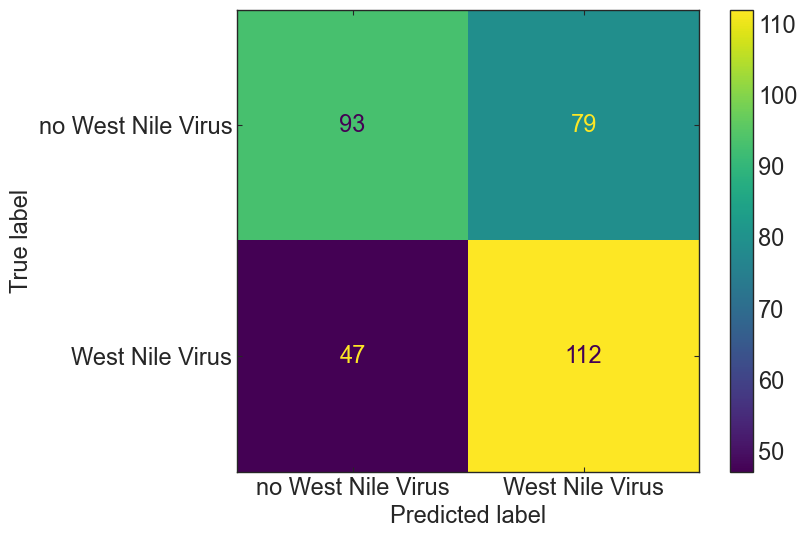

In [76]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

#ax.set_xticks([0, 1])
#ax.set_yticks([0, 1])
#ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
#ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8);

# Test Modeling 2: Random Forest Classifier

In [77]:
Rand = RandomForestClassifier(random_state=42)

In [78]:
Rand.fit(X_tr_train_scaled, y_tr_train)

RandomForestClassifier(random_state=42)

In [79]:
y_tr_test_predict = Rand.predict(X_tr_test_scaled)

In [80]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.7583081570996979


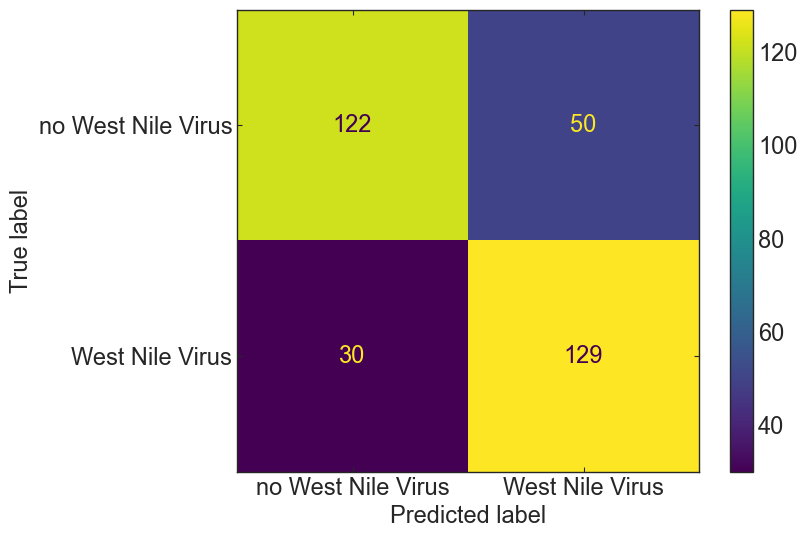

In [81]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

# Conclusion

In this preprocessing and feature engineering process, 
- re-checked the dataset and selected features of interest
- re-organized the categorical features by using label encoder
- merged two separate datasets into one which would be used for modeling
- proceeded the undersampling to mitigate the imbalanced dataset
- removed the features that are less important
- removed the features which are correlated to other features
- splitted the dataset into trainning and test ones 
- re-scaled (standardized) the dataset.

> We will perform the performance test (e.g., AUC score) for the different models in the next step.